<a href="https://colab.research.google.com/github/HaukeGS/DLF_Assignment2/blob/main/assignment2_task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.0 Imports and Initializations


In [27]:
# Imports

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.tensorboard import SummaryWriter


In [18]:
# label map
CLASS_LABEL_MAP = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1.1 Data Loading and Preprocessing


In [2]:
# download training set

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)


100%|██████████| 26.4M/26.4M [00:01<00:00, 22.5MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 349kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 6.26MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 3.93MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [20]:
# create dataloader

BATCH_SIZE = 16

dataloader = torch.utils.data.DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_validation = torch.utils.data.DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

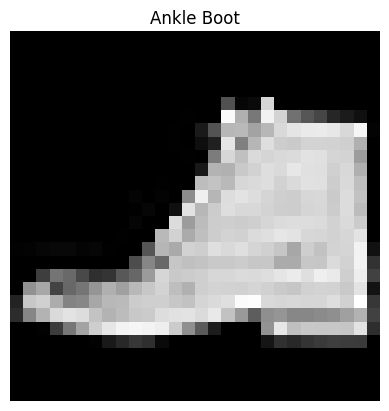

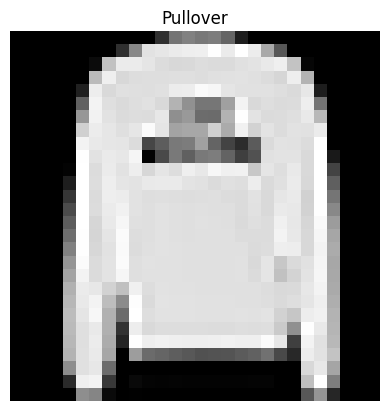

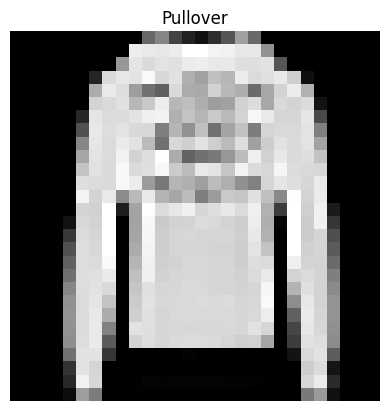

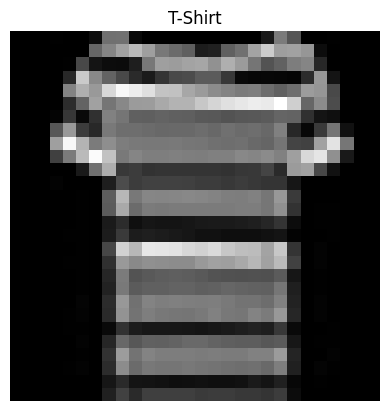

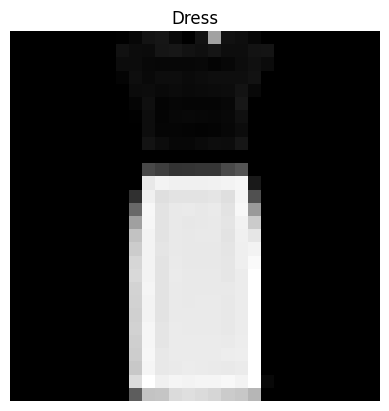

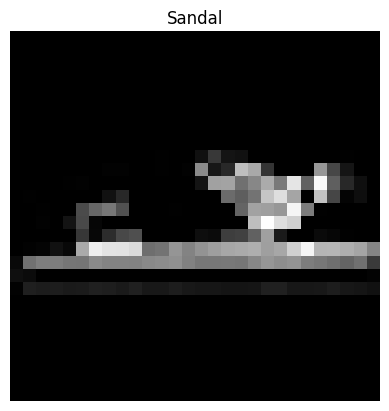

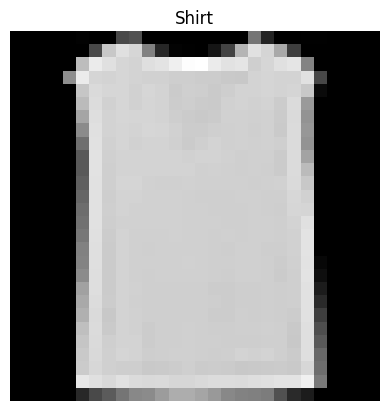

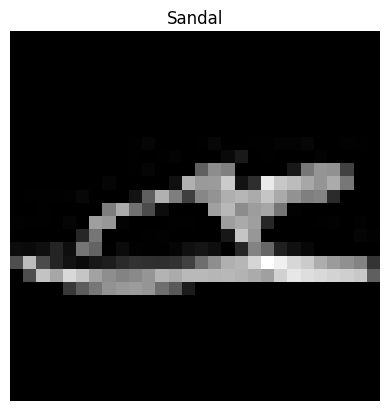

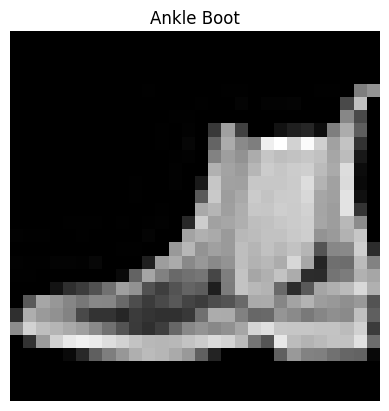

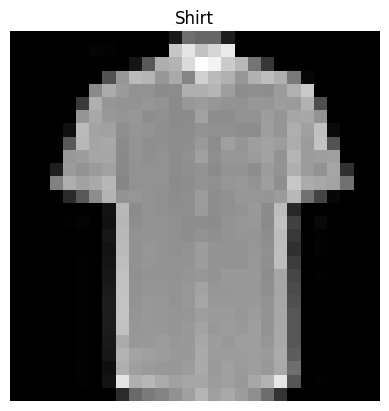

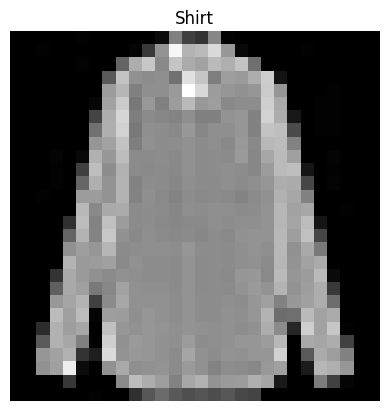

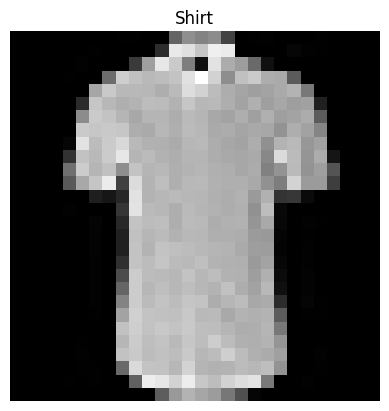

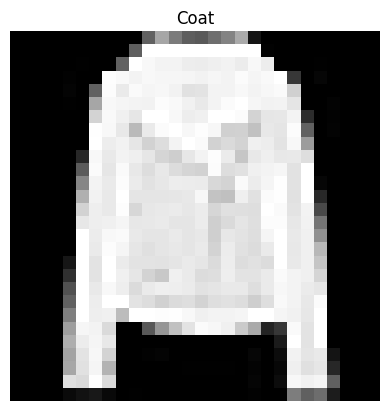

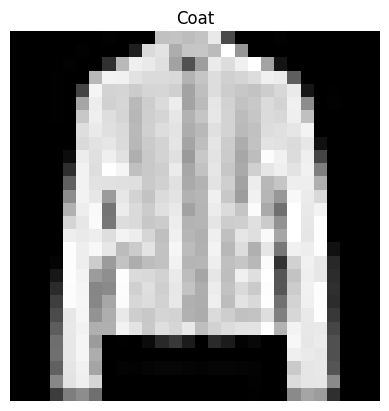

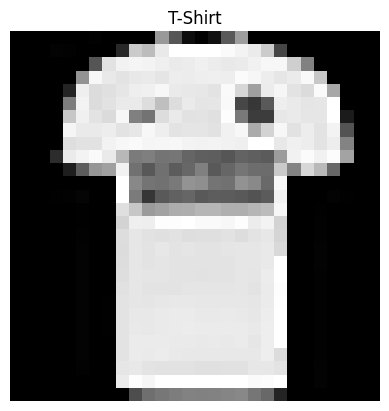

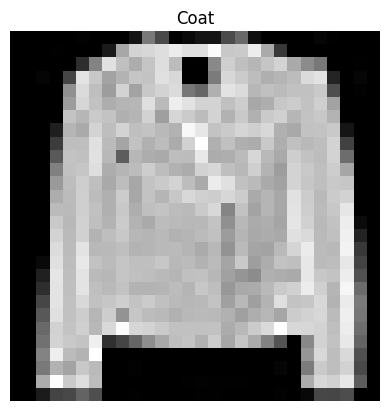

In [21]:
for images, labels in dataloader:
    for image, label in zip(images, labels):
        fig, axes = plt.subplots(1, 1)
        axes.imshow(image.squeeze(), cmap='gray')
        axes.set_title(CLASS_LABEL_MAP.get(label.item()))
        axes.axis('off')
        plt.show()
    break

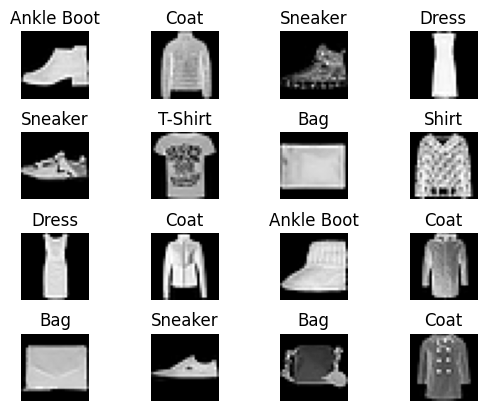

In [25]:
for images, labels in dataloader:
    fig, axes = plt.subplots(4, 4)
    for i in range(4):
        for j in range(4):
            image = images[i * 4 + j]
            label = labels[i * 4 + j]
            axes[i, j].imshow(image.squeeze(), cmap='gray')
            axes[i, j].set_title(CLASS_LABEL_MAP.get(label.item()))
            axes[i, j].axis('off')
    fig.subplots_adjust(hspace=0.5)
    plt.show()
    break

# 1.2 DCGAN Architecture

In [55]:
# Architecture Parameters

# size of latent vector z
Z_LENGTH = 100

# width and height of the images
IMAGE_SIZE = 28

# number of channels
IMAGE_CHANNELS = 1

# size of feature maps
FEATURE_MAPS = 16

### Output Dimensions of ConvTranspode2d

$H_{out}$ = $(H_{in}$ - 1) x stride - 2 x padding + dilation x (kernel_size - 1) + output_padding + 1

In [56]:
dimension = 1

layers = [
    {'in_channels': dimension, 'out_channels': FEATURE_MAPS * 2, 'kernel_size': 6, 'stride': 1, 'padding': 0},
    {'in_channels': FEATURE_MAPS * 2, 'out_channels': FEATURE_MAPS, 'kernel_size': 6, 'stride': 2, 'padding': 1},
    {'in_channels': FEATURE_MAPS, 'out_channels': 1, 'kernel_size': 6, 'stride': 2, 'padding': 2},
]

def calculate_output_dimension(layer):
    return (dimension - 1) * layer.get('stride', 1) - 2 * layer.get('padding', 0) + layer.get('dilation', 1) * (layer.get('kernel_size') - 1) + layer.get('output_padding', 0) + 1

for i, layer in enumerate(layers):
    dimension = calculate_output_dimension(layer)
    print(f"Output dimensions after layer {i}: {layer.get('out_channels')} x {dimension} x {dimension}")

Output dimensions after layer 0: 32 x 6 x 6
Output dimensions after layer 1: 16 x 14 x 14
Output dimensions after layer 2: 1 x 28 x 28


In [ ]:
# Generator

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layers = torch.nn.Sequential(

            # input is Z
            nn.ConvTranspose2d(in_channels=Z_LENGTH, out_channels=FEATURE_MAPS * 2, kernel_size=6, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(FEATURE_MAPS),
            nn.ReLU(True),
            # state size (FEATURE_MAPS * 2) x 6 x 6
            nn.ConvTranspose2d(in_channels=FEATURE_MAPS * 2, out_channels=FEATURE_MAPS, kernel_size=6, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(FEATURE_MAPS),
            nn.ReLU(True),
            # state size FEATURE_MAPS x 14 x 14
            nn.ConvTranspose2d(in_channels=FEATURE_MAPS, out_channels=IMAGE_CHANNELS, kernel_size=6, stride=2, padding=2, bias=False),
            nn.Tanh()
            # state size IMAGE_CHANNELS x 28 x 28
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
# Discriminator

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layers = torch.nn.Sequential(
            # input size is 1 x 28 x 28
            nn.Conv2d(in_channels=IMAGE_CHANNELS, out_channels=FEATURE_MAPS, kernel_size=4, stride=2, padding=0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size FEATURE_MAPS x 12 x 12
            nn.Conv2d(in_channels=FEATURE_MAPS, out_channels=FEATURE_MAPS * 2, kernel_size=4, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(FEATURE_MAPS * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (FEATURE_MAPS * 2) x 4 x 4
            nn.Conv2d(in_channels=FEATURE_MAPS * 2, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# 1.3 Training

# 1.4 Evaluation